In [1]:
FN = 'vocabulary-embedding'
seed=42
vocab_size = 40000
embedding_dim = 100
lower = False

import os
DEFAULT_PROJECT_PATH = os.environ['EXPONENTA_PROJECT_PATH']


In [2]:
import pandas as pd

In [ ]:
from data_loader import *

In [ ]:
# dataset = load_dataset(DEFAULT_PROJECT_PATH + "tg/data/articles2.csv", num_examples=None, cleanit=False)
# save_obj("articles2_", dataset, folder=DEFAULT_PROJECT_PATH + "tg/data/")

signal_dataset = load_signalmedia_json_gz()
# save_obj("signalmedia_", signal_dataset, folder=DEFAULT_PROJECT_PATH + "tg/data/")

In [5]:
# data = load_obj("articles1_", folder=DEFAULT_PROJECT_PATH + "tg/data/")

data = load_obj("signalmedia_", folder=DEFAULT_PROJECT_PATH + "tg/data/")

success: read data from /Users/MA573RWARR10R/Documents/work/kaf/sn0w_s70rm/tg/data/signalmedia_.pkl


In [7]:
len(data)

2

In [7]:
i = 666

print(data[i]['HEAD'])
print(data[i]['DESC'])

Liverpool hopes bloom after brushing aside bumbling Barcelona 4-0
always risk read too much into friendlies but the intensity shown Liverpool here suggested that after mixed they are almost ready for the real business Sadio Mané looked blisteringly sharp the right while there was defensive resilience partnership Dejan Lovren and Ragnar Klavan But arguably the most promising aspect was that the first three goals came from pressing high the pitch Jürgen Klopp style beginning take hold and will fascinating see how effective over the coming weeks word caution though Barcelona were some way off full strength showing all the signs team that remain the embryonic stage their preparations Liga does not kick off for another week and numerous key figures including Ivan Rakitic Gérard Piqué and Andrés Iniesta only returned training recent days All three were introduced hour with the game already put bed and the influence Luis Suárez making his first appearance against his former club here and Lion

In [8]:
from collections import Counter
from itertools import chain

def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount


In [9]:
headslist, descslist = list(), list()

for article in data:
    headslist.append(article['HEAD'])
    descslist.append(article['DESC'])


In [10]:
print(len(headslist),"\n", len(descslist))

25148 
 25148


In [11]:
vocab, vocabcount = get_vocab(headslist + descslist)

In [12]:
print(vocab[:50])
print('...', len(vocab))

['the', 'and', 'that', 'for', 'The', 'was', 'with', 'said', 'have', 'Trump', 'are', 'his', 'from', 'has', 'not', 'they', 'who', 'this', 'about', 'more', 'you', 'would', 'but', 'had', 'their', 'will', 'people', 'were', 'her', 'been', 'But', 'one', 'she', 'which', 'can', 'out', 'its', 'than', 'what', 'all', 'also', 'there', 'when', 'says', 'like', 'could', 'And', 'after', 'other', 'just']
... 184529


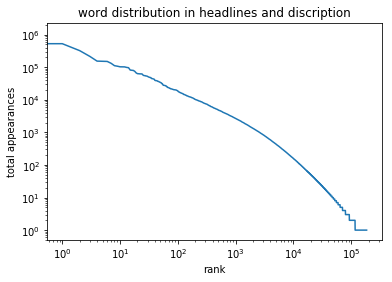

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [14]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [15]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [16]:
word2idx, idx2word = get_idx(vocab, vocabcount)

In [17]:
glove_name = "glove/glove.6B.{}d.txt".format(embedding_dim)
import os

glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [18]:
import numpy as np

glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1

with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = [float(i) for i in l[1:]]
        i += 1
        
glove_embedding_weights *= globale_scale

In [19]:
glove_embedding_weights.std()

0.04081572760019029

In [20]:
# make dict wider with words in lowercase

for w,i in glove_index_dict.items():
    w = w.lower()
    
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [21]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
        
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
number of tokens, in small vocab, found in glove and copied to embedding 38692 0.9673


lots of word in the full vocabulary (word2idx) are outside vocab_size. Build an alterantive which will map them to their closest match in glove but only if the match is good enough (cos distance above glove_thr)

In [22]:
glove_threshold = 0.7

In [23]:
word2glove = {}

for w in word2idx:
    if w in glove_index_dict:
        g = w
        
    elif w.lower() in glove_index_dict:
        g = w.lower()
        
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
        
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
        
    else:
        continue
        
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix. 
Use cos distance of GloVe vectors.

Allow for the last nb_unknown_words words inside the embedding matrix to be considered to be outside. Dont accept distances below glove_threshold


In [24]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []

for w,idx in word2idx.items():
    if idx >= vocab_size - nb_unknown_words and w.isalpha() and w in word2glove:
        
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size - nb_unknown_words], gweight)
        
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_threshold:
                break
                
            if idx2word[embedding_idx] in word2glove:
                glove_match.append((w, embedding_idx, s)) 
                break
                
            score[embedding_idx] = -1
            
glove_match.sort(key = lambda x: -x[2])

print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 27176


In [25]:
for orig, sub, score in glove_match[-25:]:
    print(score, orig,'=>', idx2word[sub])

0.7001435830652551 Wallstrom => Margot
0.7001398478177454 unobstructed => panoramic
0.7001286128140429 manioc => sorghum
0.700127651653162 ruminate => opine
0.7001212694726331 postpaid => prepaid
0.7001207840146133 Livni => Peres
0.7001190051989734 misfit => outcast
0.7001190051989734 Misfit => outcast
0.7001117388540585 Tomin => Elgood
0.7001100953394133 temperaments => WorldViews
0.7001092052940258 mismatches => mismatch
0.7001089789181384 carting => carted
0.7001080603527156 climatologist => epidemiologist
0.7001038614728194 refashioned => reinvented
0.7000958022759798 connective => tissue
0.7000779101130641 Chancellorsville => Gettysburg
0.7000734711176777 shellshocked => bewildered
0.7000734711176777 Shellshocked => bewildered
0.7000717628409694 charlatan => buffoon
0.700059485531592 fondling => molesting
0.7000400159425605 chopsticks => spoons
0.7000373177186245 Secaucus => Hoboken
0.7000257586322955 inbounds => layup
0.7000120655841535 clandestinely => covertly
0.700007808206514

build a lookup table of index of outside words to index of inside words

In [61]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

In [62]:
Y = [[word2idx[token] for token in headline.split()] for headline in headslist]
len(Y)

11221

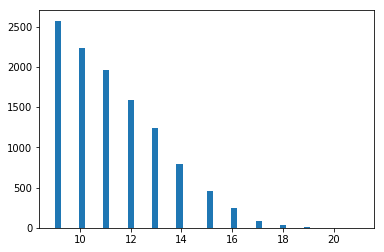

In [63]:
plt.hist([len(i) for i in Y], bins=50);

In [64]:
X = [[word2idx[token] for token in d.split()] for d in descslist]
len(X)

11221

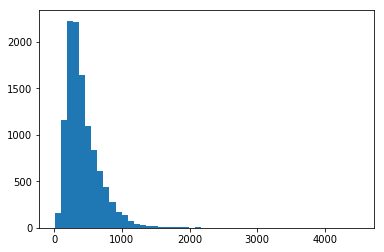

In [65]:
plt.hist([len(i) for i in X], bins=50);

In [66]:
import pickle

with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)


In [67]:
!ls -la data

total 309296
drwxr-xr-x  11 MA573RWARR10R  staff       352 Oct 31 03:45 .
drwxr-xr-x  23 MA573RWARR10R  staff       736 Oct 31 03:51 ..
-rw-r--r--@  1 MA573RWARR10R  staff      6148 Oct 27 01:37 .DS_Store
-rw-r--r--@  1 MA573RWARR10R  staff  57886802 Oct 31 03:42 foxnews.csv
-rw-r--r--   1 MA573RWARR10R  staff  32463796 Oct 31 03:45 foxnews_.pkl
-rw-r--r--@  1 MA573RWARR10R  staff  15628756 Oct 24 14:31 independent.csv
-rw-r--r--   1 MA573RWARR10R  staff        14 Oct 30 23:08 independent_.pkl
-rw-r--r--   1 MA573RWARR10R  staff  10861925 Oct 30 23:31 independent_cleaned.pkl
-rw-r--r--   1 MA573RWARR10R  staff     87746 Oct 26 21:56 vocab.pkl
-rw-r--r--   1 MA573RWARR10R  staff   4268938 Oct 30 23:40 vocabulary-embedding.data.pkl
-rw-r--r--   1 MA573RWARR10R  staff  36110145 Oct 31 03:52 vocabulary-embedding.pkl


In [68]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)